In [12]:
'''
Filename: /home/richard/workspace/ICBHI-chanllenge/scripts/data_analysis.ipynb
Path: /home/richard/workspace/ICBHI-chanllenge/scripts
Created Date: Thursday, January 30th 2025, 2:47:15 pm
Author: richard

Copyright (c) 2025 Richard.Rao
'''
import librosa
import json
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load meta data
diagnosis = pd.read_csv('./meta_data/ICBHI_Challenge_diagnosis.csv')
# Load filelist
filelist = pd.read_csv('./meta_data/ICBHI_challenge_train_test.csv')

# create a folder for intermediate result
result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# translate into Chineses
print(diagnosis['diagnosis'].unique())
# For my own convenience, I translate the disease names into Chinese for better understanding
translate_cheatsheeet = {\
        'COPD': '慢性阻塞性肺病', \
        'URTI': '上呼吸道感染', \
        'Bronchiectasis': '支气管扩张', \
        'Bronchiolitis': '支气管炎', \
        'Pneumonia': '肺炎', \
        'Healthy': '健康', \
        'Asthma': '哮喘', \
        'LRTI': '下呼吸道感染'}

diagnosis_codebook = {\
    'COPD': 0, 'URTI': 1, 'Bronchiectasis': 2, 'Bronchiolitis': 3, 'Pneumonia': 4, 'Healthy': 5, 'Asthma': 6, 'LRTI': 7}
chestloc_codebook = {\
    'Al': 0, 'Pr': 1, 'Ar':2, 'Ll': 3, 'Lr': 4, 'Pl':5, 'Tc':6}
devices_codebook = {\
    'Meditron':0, 'LittC2SE':1, 'Litt3200':2, 'AKGC417L': 3}

playlist = []
# load everything into 1 table
for idx, row in filelist.iterrows():
    file_id = row['file_id']
    file_info = file_id.split('_')
    patient_id = int(file_info[0])
    recording_index = file_info[1]
    chest_location = file_info[2]
    channels = file_info[3]
    acq_device = file_info[4]
    # Save information into the filelist
    filelist.loc[idx, 'patient_id'] = patient_id
    filelist.loc[idx, 'recording_index'] = recording_index
    filelist.loc[idx, 'chest_location'] = chest_location
    filelist.loc[idx, 'channels'] = channels
    filelist.loc[idx, 'acq_device'] = acq_device
    
    # load the text file
    txt_file = './data/' + file_id + '.txt'
    meta_info = {'start': [], 'stop': [], 'crackles': [], 'wheezes': []}
    with open(txt_file, 'r') as f:
        contents = f.readlines()
        
        contents = [x.strip() for x in contents]
        # Save information into the filelist
        for line in contents:
            line = line.split('\t')
            meta_info['start'].append(float(line[0]))
            meta_info['stop'].append(float(line[1]))
            meta_info['crackles'].append(int(line[2]))
            meta_info['wheezes'].append(int(line[3]))
    # Save information into the filelist
    filelist.loc[idx, 'meta_info'] = "{:s}".format(json.dumps(meta_info)) # save as string
    # print(json.loads(filelist.loc[idx, 'meta_info']))
# join the diagnosis table with the filelist table
filelist = pd.merge(filelist, diagnosis, on='patient_id')
display(filelist.head())

['URTI' 'Healthy' 'Asthma' 'COPD' 'LRTI' 'Bronchiectasis' 'Pneumonia'
 'Bronchiolitis']


file_id    tag  patient_id recording_index chest_location  \
0  101_1b1_Al_sc_Meditron   test       101.0             1b1             Al   
1  101_1b1_Pr_sc_Meditron   test       101.0             1b1             Pr   
2  102_1b1_Ar_sc_Meditron   test       102.0             1b1             Ar   
3  103_2b2_Ar_mc_LittC2SE  train       103.0             2b2             Ar   
4  104_1b1_Al_sc_Litt3200   test       104.0             1b1             Al   

  channels acq_device                                          meta_info  \
0       sc   Meditron  {"start": [0.036, 0.579, 2.45, 3.893, 5.793, 7...   
1       sc   Meditron  {"start": [0.036, 1.264, 3.422, 5.55, 7.436, 9...   
2       sc   Meditron  {"start": [0.264, 1.736, 3.293, 5.307, 6.636, ...   
3       mc   LittC2SE  {"start": [0.364, 3.25, 6.636, 11.179, 14.25, ...   
4       sc   Litt3200  {"start": [0.0, 1.8771, 3.7543, 6.1071, 8.2502...   

  diagnosis  
0      URTI  
1      URTI  
2   Healthy  
3    Asthma  
4      COPD

### Feature extraction

In [24]:
from tqdm import tqdm
nmfcc = 13
nmel = 64

melspec_pairs = np.empty((0, nmel + 5))
# mfcc_pairs = np.empty((0, nmfcc + 5))

for idx, row in tqdm(filelist.iterrows()):
    file_id = row['file_id']
    audio_file = os.path.join('./data/', file_id + '.wav')
    meta_info = json.loads(row['meta_info'])
    y, sr = librosa.load(audio_file, sr=None)
    # Normalize the audio
    y = y / np.max(np.abs(y))
    # extract the MFCC feature, PLP feature, and Mel-spectrogram
    for sec_id in range(len(meta_info["start"])):
        start = int(meta_info["start"][sec_id] * sr)
        stop = int(meta_info["stop"][sec_id] * sr)
        # extract the audio
        segment = y[start:stop]
        # extract the MFCC feature
        # mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=nmfcc)
        # extract the Mel-spectrogram
        mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=nmel)
        mel_dB = librosa.power_to_db(mel, ref=np.max)
        # Put features into a long tensor and has the shape of (n_features, n_frames) meanwhile
        # put the label into a list which has the same length as the number of frames
        # Save the features into a file
        nframes = mel.shape[1]
        # mfcc_pairs = np.vstack((mfcc_pairs, np.hstack((
        #     mfcc.T, \
        #     np.ones((nframes,1)) * chestloc_codebook[row['chest_location']], \
        #     np.ones((nframes,1)) * devices_codebook[row['acq_device']], \
        #     np.ones((nframes,1)) * diagnosis_codebook[row['diagnosis']], \
        #     np.ones((nframes,1)) * meta_info['crackles'][sec_id], \
        #     np.ones((nframes,1)) * meta_info['wheezes'][sec_id]))))
        melspec_pairs = np.vstack((melspec_pairs, np.hstack((
            mel_dB.T, \
            np.ones((nframes,1)) * chestloc_codebook[row['chest_location']], \
            np.ones((nframes,1)) * devices_codebook[row['acq_device']], \
            np.ones((nframes,1)) * diagnosis_codebook[row['diagnosis']], \
            np.ones((nframes,1)) * meta_info['crackles'][sec_id], \
            np.ones((nframes,1)) * meta_info['wheezes'][sec_id]))))
        # print(mel.shape)
# save the features into a file
# np.save(result_folder + 'mfcc_pairs.npy', mfcc_pairs)
np.save(result_folder + 'melspec_pairs.npy', melspec_pairs)
        

43it [00:02, 13.66it/s]/home/richard/anaconda3/envs/hifigan/lib/python3.9/site-packages/librosa/core/spectrum.py:265: UserWarning: n_fft=2048 is too large for input signal of length=1848
  warnings.warn(
920it [06:30,  2.36it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

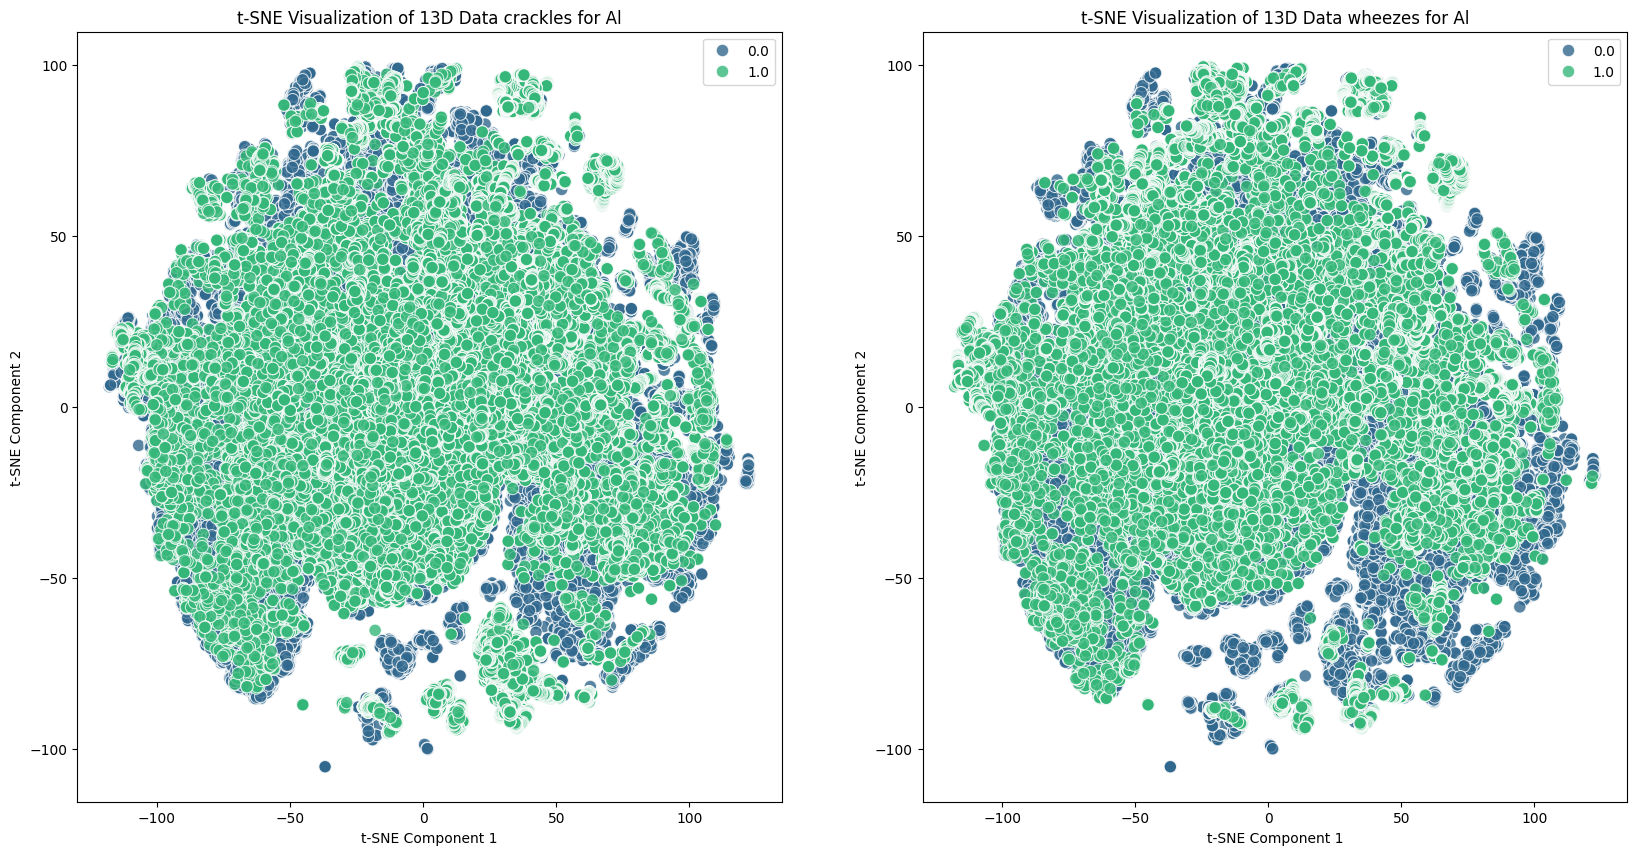

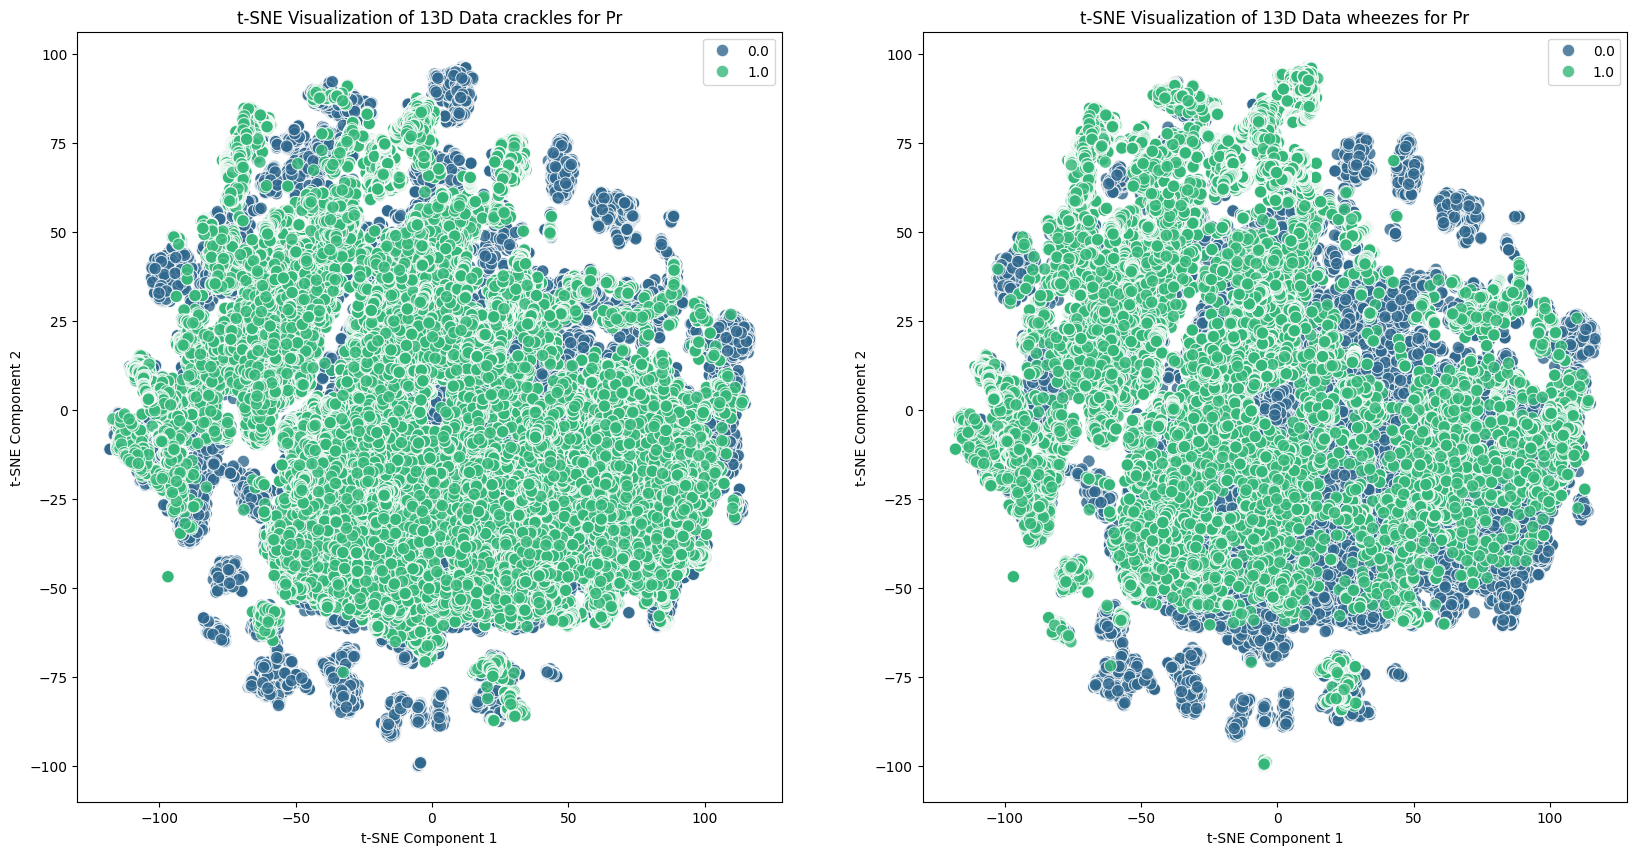

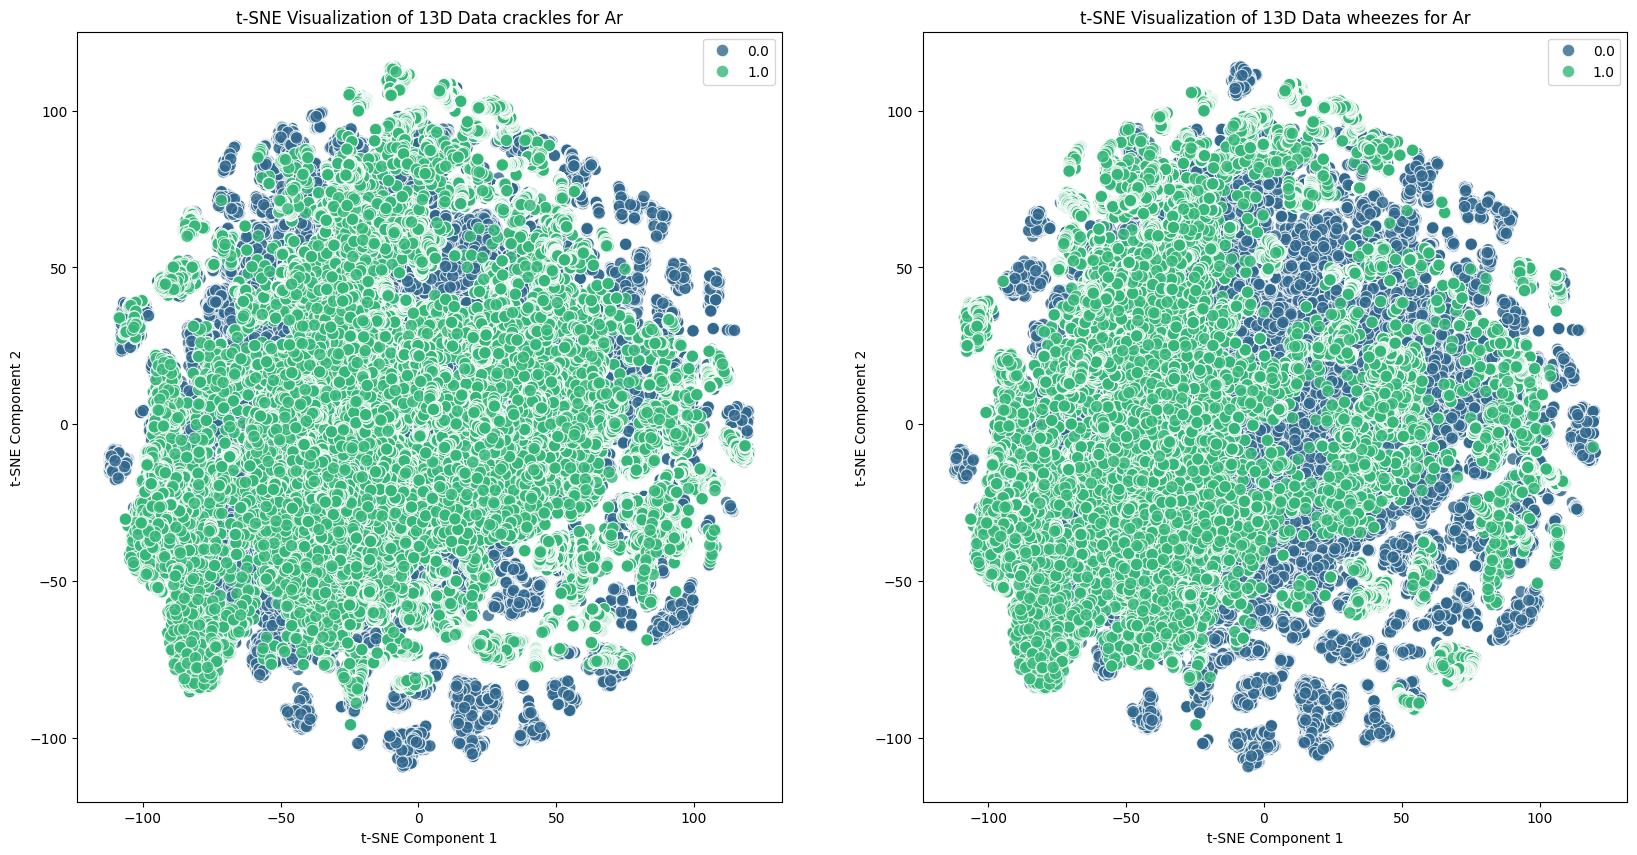

In [29]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# mfcc_pairs = np.load(result_folder + 'mfcc_pairs.npy')
melspec_pairs = np.load(result_folder + 'melspec_pairs.npy')

for chest_loc in chestloc_codebook.keys():
    idx = np.where((melspec_pairs[:, -5] == chestloc_codebook[chest_loc]))[0]
    if len(idx) == 0:
        print('No data for ' + chest_loc)
        continue
    x = melspec_pairs[idx, :-5]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(x)
    tsne = TSNE(n_components=2, perplexity=50)
    X_embedded = tsne.fit_transform(X_scaled)
    df = pd.DataFrame(X_embedded, columns=['TSNE-1', 'TSNE-2'])
    df['crackles'] = melspec_pairs[idx, -2]
    df['wheezes'] = melspec_pairs[idx, -1]
    
    crackles_0 = df[df['crackles'] == 0]
    crackles_1 = df[df['crackles'] == 1]
    if len(crackles_1) > len(crackles_0):
        crackles_1 = crackles_1.sample(n=len(crackles_0), random_state=42)
        df_crackles = pd.concat([crackles_0, crackles_1])
    else:
        crackles_0 = crackles_0.sample(n=len(crackles_1), random_state=42)
        df_crackles = pd.concat([crackles_0, crackles_1])

    wheezes_0 = df[df['wheezes'] == 0]
    wheezes_1 = df[df['wheezes'] == 1]
    if len(wheezes_1) > len(wheezes_0):
        wheezes_1 = wheezes_1.sample(n=len(wheezes_0), random_state=42)
        df_wheezes = pd.concat([wheezes_0, wheezes_1])
    else:
        wheezes_0 = wheezes_0.sample(n=len(wheezes_1), random_state=42)
        df_wheezes = pd.concat([wheezes_0, wheezes_1])

    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.scatterplot(x='TSNE-1', y='TSNE-2', hue='crackles', palette='viridis', data=df_crackles, alpha=0.8, s=80, ax=ax[0])
    ax[0].set_title('t-SNE Visualization of 13D Data crackles for ' + chest_loc)
    ax[0].set_xlabel('t-SNE Component 1')
    ax[0].set_ylabel('t-SNE Component 2')
    ax[0].legend()
    sns.scatterplot(x='TSNE-1', y='TSNE-2', hue='wheezes', palette='viridis', data=df_wheezes, alpha=0.8, s=80, ax=ax[1])
    ax[1].set_title('t-SNE Visualization of 13D Data wheezes for ' + chest_loc)
    ax[1].set_xlabel('t-SNE Component 1')
    ax[1].set_ylabel('t-SNE Component 2')
    ax[1].legend()

    # f,ax = plt.subplots(1, 2, figsize=(20, 10))
    # sns.scatterplot(x='TSNE-1', y='TSNE-2', hue=df['crackles'], palette='viridis', data=df, alpha=0.8, s=80, ax=ax[0], color=['blue', 'red'])
    # ax[0].set_title('t-SNE Visualization of 13D Data crackles for ' + chest_loc)
    # ax[0].set_xlabel('t-SNE Component 1')
    # ax[0].set_ylabel('t-SNE Component 2')
    # ax[0].legend()
    # sns.scatterplot(x='TSNE-1', y='TSNE-2', hue=df['wheezes'], palette='viridis', data=df, alpha=0.8, s=80, ax=ax[1], color=['blue', 'red'] )
    # ax[1].set_title('t-SNE Visualization of 13D Data wheezes for ' + chest_loc)
    # ax[1].set_xlabel('t-SNE Component 1')
    # ax[1].set_ylabel('t-SNE Component 2')
    # ax[1].legend()

# for device in devices_codebook.keys():
# & (melspec_pairs[:, -4] == devices_codebook[device])

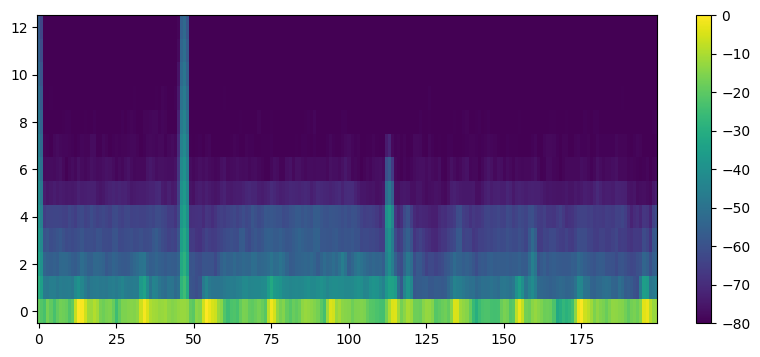

In [23]:
# plot x 
plt.figure(figsize=(10, 4))
plt.imshow(melspec_pairs[0:200, :-5].T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()